On commence par un modèle Naif: On prévoit à J+7(8) la valeur moyenne de la journée actuelle.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
stations_debit = pd.read_csv("../Data/Base/Stations_Debit.csv")
liste_stations = list(stations_debit["Code station"])

In [3]:
mesures_train_X = pd.read_csv("../Data/Base/Mesures_Train_X.csv")
mesures_train_X["Date"] = pd.to_datetime(mesures_train_X["Date"], format = "%Y/%m/%d %H:%M:%S")
mesures_train_Y = pd.read_csv("../Data/Base/Mesures_Train_Y.csv")
mesures_train_Y["Date"] = pd.to_datetime(mesures_train_Y["Date"], format = "%Y/%m/%d %H:%M:%S")

train_split_X = pd.read_csv("../Data/Base/Index_CV_X.csv")
train_split_Y = pd.read_csv("../Data/Base/Index_CV_Y.csv")

mesures_test_X = pd.read_csv("../Data/Base/Mesures_Test_X.csv")
mesures_test_X["Date"] = pd.to_datetime(mesures_test_X["Date"], format = "%Y/%m/%d %H:%M:%S")
mesures_test_Y = pd.read_csv("../Data/Base/Mesures_Test_Y.csv")
mesures_test_Y["Date"] = pd.to_datetime(mesures_test_Y["Date"], format = "%Y/%m/%d %H:%M:%S")

Pas besoin d'entrainer de modèle on apprend rien, on fait juste une moyenne et on extrapole.

In [4]:
%run Modele_Naif_fcts.py
%run Eval_fcts.py
%run Standardize_fcts.py

## Score de Validation croisée.

In [5]:
cv_scores_RMSE_standard = pd.DataFrame({"Code station": liste_stations})
cv_scores_MAE_standard = pd.DataFrame({"Code station": liste_stations})
cv_scores_R2_standard = pd.DataFrame({"Code station": liste_stations})
    
cv_scores_RMSE = pd.DataFrame({"Code station": liste_stations})
cv_scores_MAE = pd.DataFrame({"Code station": liste_stations})
cv_scores_R2 = pd.DataFrame({"Code station": liste_stations})

for curr_split in tqdm(range(9)):
    
    curr_train_X = mesures_train_X[train_split_X["Train_" + str(curr_split)]]
    curr_train_X_mean = curr_train_X[liste_stations].mean()
    curr_train_X_std = curr_train_X[liste_stations].std()
    curr_test_X = mesures_train_X[train_split_X["Test_" + str(curr_split)]]
    curr_test_Y = mesures_train_Y[train_split_Y["Test_" + str(curr_split)]]
    liste_dates = curr_test_Y["Date"]
    predictions_Y = fct_Modele_Naif(curr_test_X, liste_dates, liste_stations)

    # Scores
    curr_scores_RMSE = fct_RMSE(curr_test_Y, predictions_Y, liste_stations)
    cv_scores_RMSE["Split_" + str(curr_split)] = curr_scores_RMSE["RMSE"]
    curr_scores_MAE = fct_MAE(curr_test_Y, predictions_Y, liste_stations)
    cv_scores_MAE["Split_" + str(curr_split)] = curr_scores_MAE["MAE"]
    curr_scores_R2 = fct_R2(curr_test_Y, predictions_Y, liste_stations)
    cv_scores_R2["Split_" + str(curr_split)] = curr_scores_R2["R2"]
    # Scores standards
    predictions_Y_standard = fct_Standardize(predictions_Y,
                                             curr_train_X_mean, curr_train_X_std,
                                             liste_stations)
    predictions_Y_standard["Date"] = predictions_Y["Date"]
    curr_test_Y_standard = fct_Standardize(curr_test_Y,
                                             curr_train_X_mean, curr_train_X_std,
                                             liste_stations)
    curr_test_Y_standard["Date"] = curr_test_Y["Date"]
    curr_RMSE = fct_RMSE(curr_test_Y_standard, predictions_Y_standard, liste_stations)
    cv_scores_RMSE_standard["Split_" + str(curr_split)] = curr_RMSE["RMSE"]
    curr_MAE = fct_MAE(curr_test_Y_standard, predictions_Y_standard, liste_stations)
    cv_scores_MAE_standard["Split_" + str(curr_split)] = curr_MAE["MAE"]
    curr_R2 = fct_R2(curr_test_Y_standard, predictions_Y_standard, liste_stations)
    cv_scores_R2_standard["Split_" + str(curr_split)] = curr_R2["R2"]

100%|██████████| 9/9 [00:03<00:00,  2.90it/s]


In [6]:
cv_moyen_RMSE_standard = []
cv_moyen_MAE_standard = []
cv_moyen_R2_standard = []
    
cv_moyen_RMSE = []
cv_moyen_MAE = []
cv_moyen_R2 = []

for code in liste_stations:
    score_RMSE = np.mean(cv_scores_RMSE_standard[cv_scores_RMSE_standard["Code station"] == code][["Split_" + str(i) for i in range(9)]].iloc[0,:])
    cv_moyen_RMSE_standard.append(score_RMSE)
    score_MAE = np.mean(cv_scores_MAE_standard[cv_scores_MAE_standard["Code station"] == code][["Split_" + str(i) for i in range(9)]].iloc[0,:])
    cv_moyen_MAE_standard.append(score_MAE)
    score_R2 = np.mean(cv_scores_R2_standard[cv_scores_R2_standard["Code station"] == code][["Split_" + str(i) for i in range(9)]].iloc[0,:])
    cv_moyen_R2_standard.append(score_R2)
    score_RMSE = np.mean(cv_scores_RMSE[cv_scores_RMSE["Code station"] == code][["Split_" + str(i) for i in range(9)]].iloc[0,:])
    cv_moyen_RMSE.append(score_RMSE)
    score_MAE = np.mean(cv_scores_MAE[cv_scores_MAE["Code station"] == code][["Split_" + str(i) for i in range(9)]].iloc[0,:])
    cv_moyen_MAE.append(score_MAE)
    score_R2 = np.mean(cv_scores_R2[cv_scores_R2["Code station"] == code][["Split_" + str(i) for i in range(9)]].iloc[0,:])
    cv_moyen_R2.append(score_R2)

cv_scores_RMSE_standard["Moyenne"] = cv_moyen_RMSE_standard
cv_scores_RMSE_standard.to_csv("../Data/Naif/CV_RMSE_standard.csv",
                          index=False)
cv_scores_MAE_standard["Moyenne"] = cv_moyen_MAE_standard
cv_scores_MAE_standard.to_csv("../Data/Naif/CV_MAE_standard.csv",
                          index=False)
cv_scores_R2_standard["Moyenne"] = cv_moyen_R2_standard
cv_scores_R2_standard.to_csv("../Data/Naif/CV_R2_standard.csv",
                          index=False)
cv_scores_RMSE["Moyenne"] = cv_moyen_RMSE
cv_scores_RMSE.to_csv("../Data/Naif/CV_RMSE.csv",
                          index=False)
cv_scores_MAE["Moyenne"] = cv_moyen_MAE
cv_scores_MAE.to_csv("../Data/Naif/CV_MAE.csv",
                          index=False)
cv_scores_R2["Moyenne"] = cv_moyen_R2
cv_scores_R2.to_csv("../Data/Naif/CV_R2.csv",
                          index=False)

<AxesSubplot:ylabel='Density'>

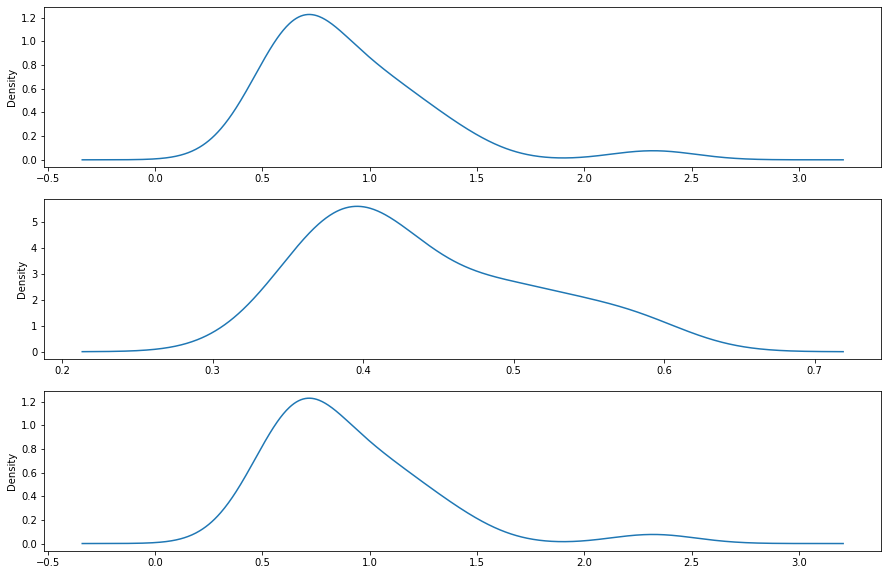

In [7]:
fig, axs = plt.subplots(3, 1, figsize = (15,10))
cv_scores_RMSE_standard["Moyenne"].plot.density(ax = axs[0])
cv_scores_MAE_standard["Moyenne"].plot.density(ax = axs[1])
cv_scores_RMSE_standard["Moyenne"].plot.density(ax = axs[2])

### Scores standards moyens

In [8]:
cv_moyen = pd.read_csv("../Data/Naif/CV_RMSE_standard.csv")["Moyenne"]
cv_moyen.mean()

0.9055013425008165

In [9]:
cv_moyen = pd.read_csv("../Data/Naif/CV_MAE_standard.csv")["Moyenne"]
cv_moyen.mean()

0.43987499938371255

In [10]:
cv_moyen = pd.read_csv("../Data/Naif/CV_R2_standard.csv")["Moyenne"]
cv_moyen.mean()

0.9897891422759089

# Score sur l'ensemble de test

In [11]:
liste_dates = mesures_test_Y["Date"]

predictions_test_Y = fct_Modele_Naif(mesures_test_X, liste_dates, liste_stations)
scores_RMSE = fct_RMSE(mesures_test_Y, predictions_test_Y, liste_stations)
scores_MAE = fct_MAE(mesures_test_Y, predictions_test_Y, liste_stations)
scores_R2 = fct_R2(mesures_test_Y, predictions_test_Y, liste_stations)

test_scores = pd.DataFrame({"Code station": liste_stations,
                            "RMSE": scores_RMSE["RMSE"],
                            "MAE": scores_MAE["MAE"],
                            "R2": scores_R2["R2"]})
test_scores

,Code station,RMSE,MAE,R2
0,O0200020,27.600964,15.500545,1.002334
1,O2620010,180.860040,94.658523,0.979575
2,O6140010,331.834018,185.624858,0.924707
3,O9000010,519.794150,288.706866,0.886536
4,K0030020,5.166327,0.875275,0.999572
5,K0100020,7.696762,1.763393,1.000890
6,K0260020,22.470999,5.329458,0.998906
7,K0550010,44.819668,11.883073,0.999143
8,K0690010,60.290965,21.197950,0.992102
9,K0910050,60.552842,21.180114,0.997470


In [12]:
test_scores.to_csv("../Data/Naif/Test_scores.csv",
                   index=False)

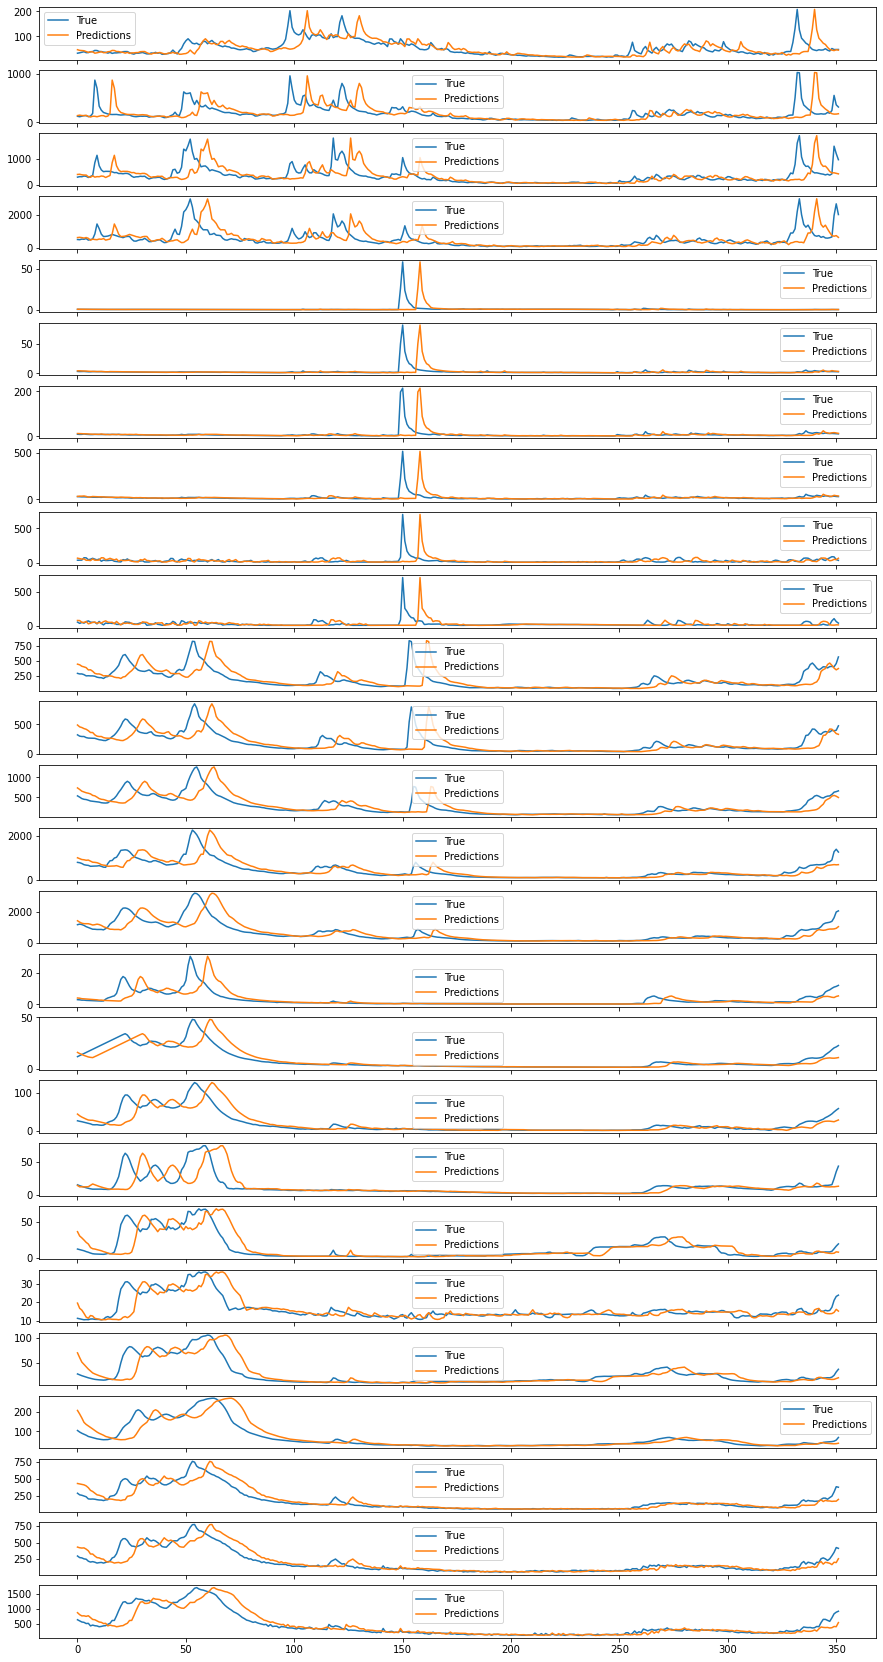

In [13]:
n_stations = len(liste_stations)
fig, axs = plt.subplots(n_stations, 1, figsize = (15,30), sharex=True)
for i in range(n_stations):
    code = liste_stations[i]
    axs[i].plot(mesures_test_Y[code], label = "True")
    axs[i].plot(predictions_test_Y[code], label = "Predictions")
    axs[i].legend()

### Standard

In [14]:
mesures_train_X_mean = mesures_train_X[liste_stations].mean()
mesures_train_X_std = mesures_train_X[liste_stations].std()
predictions_test_Y_standard = fct_Standardize(predictions_test_Y,
                                              mesures_train_X_mean, mesures_train_X_std,
                                              liste_stations)
predictions_test_Y_standard["Date"] = predictions_test_Y["Date"]
mesures_test_Y_standard = fct_Standardize(mesures_test_Y,
                                          mesures_train_X_mean, mesures_train_X_std,
                                          liste_stations)
mesures_test_Y_standard["Date"] = mesures_test_Y["Date"]
scores_RMSE_standard = fct_RMSE(mesures_test_Y_standard, predictions_test_Y_standard, liste_stations)
scores_MAE_standard = fct_MAE(mesures_test_Y_standard, predictions_test_Y_standard, liste_stations)
scores_R2_standard = fct_R2(mesures_test_Y_standard, predictions_test_Y_standard, liste_stations)

test_scores_standard = pd.DataFrame({"Code station": liste_stations,
                            "RMSE": scores_RMSE_standard["RMSE"],
                            "MAE": scores_MAE_standard["MAE"],
                            "R2": scores_R2_standard["R2"]})
test_scores_standard

,Code station,RMSE,MAE,R2
0,O0200020,0.594571,0.333908,1.002334
1,O2620010,0.912448,0.477557,0.979575
2,O6140010,1.008488,0.564139,0.924707
3,O9000010,1.069062,0.593784,0.886536
4,K0030020,0.842440,0.142725,0.999572
5,K0100020,0.817428,0.187280,1.000890
6,K0260020,1.213043,0.287698,0.998906
7,K0550010,1.230213,0.326167,0.999143
8,K0690010,1.347688,0.473839,0.992102
9,K0910050,1.048670,0.366803,0.997470


In [15]:
test_scores_standard.to_csv("../Data/Naif/Test_scores_standard.csv",
                   index=False)

In [16]:
test_scores_standard[["RMSE", "MAE", "R2"]].mean()

RMSE    0.705497
MAE     0.317238
R2      0.990315
dtype: float64

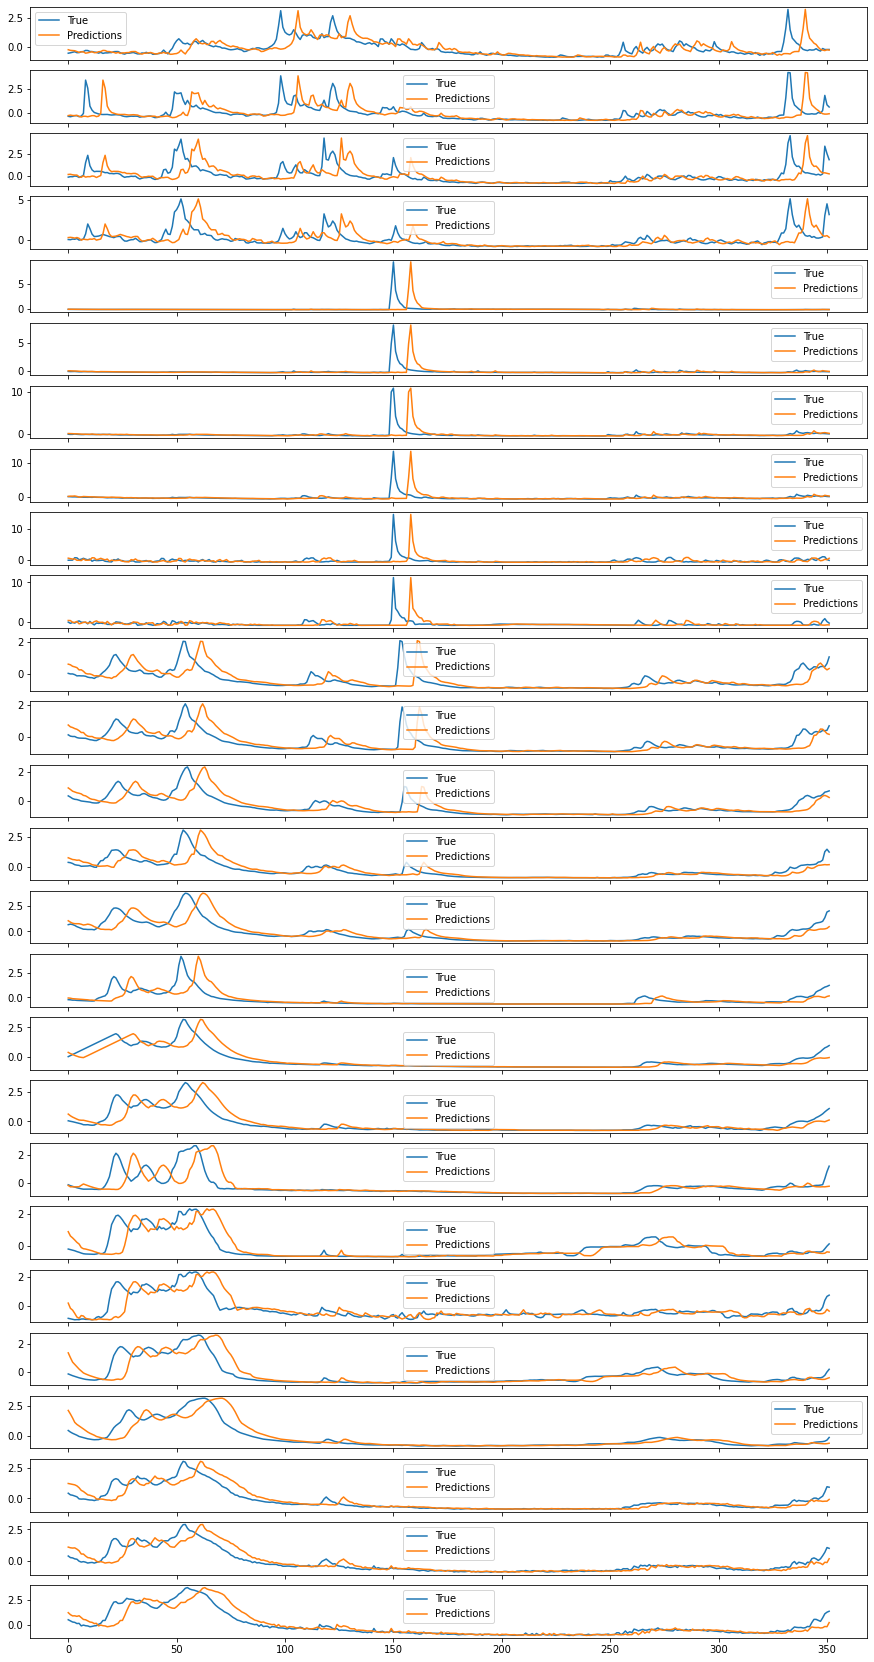

In [17]:
n_stations = len(liste_stations)
fig, axs = plt.subplots(n_stations, 1, figsize = (15,30), sharex=True)
for i in range(n_stations):
    code = liste_stations[i]
    axs[i].plot(mesures_test_Y_standard[code], label = "True")
    axs[i].plot(predictions_test_Y_standard[code], label = "Predictions")
    axs[i].legend()